[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SilverViking/deep-learning-biology/blob/main/exercises/assignments/2020-dlb-5-unsupervised-neural-networks.ipynb)

# Exercise 5: Unsupervised neural networks

In this notebook, we will be see how autoencoders can be used for clustering and semi-supervised classification. 

The structure of these exercises is as follows: 

1. [Import libraries and download data](#scrollTo=ScagUEMTMjlK)
2. [Data pre-processing](#scrollTo=ohZHyOTnI35b)
3. [Building an autoencoder](#scrollTo=kIry8iFZI35y)
4. [Clustering with autoencoders](#scrollTo=uXrEb0rTI35-)
5. [Semi-supervised classification](#scrollTo=kEU34VvDUPr_)

## 1. Import libraries and download data
Let's start with importing the necessary libraries. 

In [1]:
import pickle
import numpy as np
import random
import os
import matplotlib.pyplot as plt
plt.rcdefaults()
import pandas as pd
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, metrics
from progressbar import ProgressBar, Percentage, Bar, ETA, FileTransferSpeed
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
import gdown
import zipfile
import os

As you will notice, Colab environments come with quite a large library pre-installed. If you need to import a module that is not yet specified, you can add it in the previous cell (make sure to run it again). If the module is not installed, you can install it with `pip`. 

To make your work reproducible, it is advised to initialize all modules with stochastic functionality with a fixed seed. Re-running this script should give the same results as long as the seed is fixed. 

In [2]:
# make sure the results are reproducible
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run all computations on the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running computations with %s' % torch.device(device))
if torch.cuda.is_available():
    print(torch.cuda.get_device_properties(device))

Running computations with cuda
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


## 2. Data pre-processing

We will use the well-known MNIST benchmarking dataset. This dataset is well-known in the world of machine learning. It consists of relatively small $28 \times 28$ pixel images of digits. The goals of the dataset is to classify the digit images to the actual number that is on the image. 

In [3]:
# batch size for the dataloader
batch_size = 64

# data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, 
                   transform=transforms.ToTensor()), batch_size=batch_size, 
                   shuffle=False)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True, 
                   transform=transforms.ToTensor()), batch_size=batch_size, 
                   shuffle=False)

# print statistics
print('The train data consists of %d samples' % len(train_loader.dataset))
print('The test data consists of %d samples' % len(test_loader.dataset))

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!
The train data consists of 60000 samples
The test data consists of 10000 samples


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Here are a few examples of the data, the corresponding label is on top of each image. 

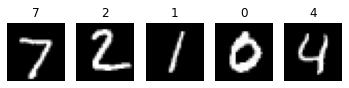

In [7]:
# visualize the data
n = 5
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(test_loader.dataset[i][0].numpy()[0, ...], cmap='gray')
    plt.title(test_loader.dataset[i][1])
    plt.axis('off')
plt.show()

## 3. Building an autoencoder

Now, we have to implement the autoencoder and train it. Let's start by defining the architecture. 

**Exercise**: build an autoencoder with a single hidden layer. Not that every pixel in the image corresponds to an input dimension, i.e. the input and output of the autoencoder will be $28 \times 28$ dimensional and images will have to be reshaped in vector format. Implement the following architecture: 
- The first layer (encoder) will be a [fully connected layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) with [sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) activation that transforms the input features to a 64 dimensional (hidden) feature vector representation. 
- The second layer (decoder) is another [fully connected layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) that transforms the hidden representation to the original input dimensions. 
- Print the network architecture and propagate a test sample to validate your architecture. 

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


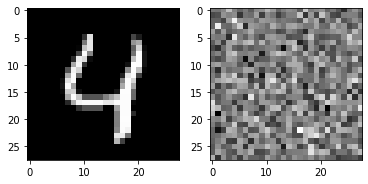

In [16]:
class AutoEncoder(nn.Module):
    
    def __init__(self, dim_input, dim_hidden):
        super().__init__()

        """
        INSERT CODE HERE
        """
        self.encoder = nn.Sequential(nn.Linear(dim_input, dim_hidden), nn.Sigmoid())
        self.decoder = nn.Sequential(nn.Linear(dim_hidden, dim_input), nn.Sigmoid())

    def forward(self, x):

        """
        INSERT CODE HERE
        """
        x = self.encoder(x)
        x = self.decoder(x)
        return x

dim_hidden = 64
"""
INSERT CODE HERE
"""
net_ae = AutoEncoder(28 * 28, dim_hidden)
print(net_ae)

# propagate a sample
"""
INSERT CODE HERE
"""
label = test_loader.dataset[i][1]
img_in = test_loader.dataset[i][0].view(-1, 28 * 28)  # view(-1, 28 * 28) to flatten the image to a vector
img_out = net_ae(img_in)

# show the result
"""
INSERT CODE HERE
"""
plt.subplot(1, 2, 1)
plt.imshow(img_in.view(28, 28).numpy(), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(img_out.view(28, 28).detach().numpy(), cmap='gray')
plt.show()

Time to train the network now! Remember, a single training iteration consists of the following steps: 
1. Construct a batch
2. Zero the gradients
3. Forward propagation
4. Compute the loss
5. Backward propagation
6. Update the weights

**Exercise**: train the autoencoder for 10 epochs on the data. 
- Map the autoencoder to the computing device
- Define an Adam optimizer, with a learning rate of $10^{-2}$ and weight decay of $10^{-5}$
- Define a mean squared error (MSE) loss function
- Fill in the missing code in the `train_epoch` and `test_epoch` functions
- Run the autoencoder on a sample and show the obtained reconstruction

Epoch 1/10: Train loss = 0.0360 - Test loss = 0.0265
Epoch 2/10: Train loss = 0.0244 - Test loss = 0.0244
Epoch 3/10: Train loss = 0.0230 - Test loss = 0.0236
Epoch 4/10: Train loss = 0.0222 - Test loss = 0.0233
Epoch 5/10: Train loss = 0.0218 - Test loss = 0.0230
Epoch 6/10: Train loss = 0.0216 - Test loss = 0.0230
Epoch 7/10: Train loss = 0.0215 - Test loss = 0.0230
Epoch 8/10: Train loss = 0.0214 - Test loss = 0.0231
Epoch 9/10: Train loss = 0.0214 - Test loss = 0.0230
Epoch 10/10: Train loss = 0.0213 - Test loss = 0.0229


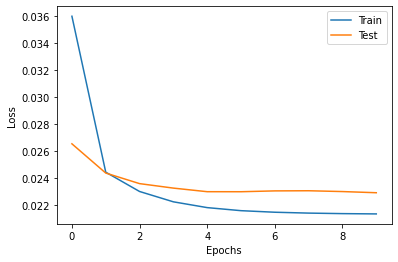

In [18]:
# train for one epoch
def train_epoch(net, loader, optimizer, criterion, device): 
    net.train()
    loss_avg = 0
    for x, _ in loader:
        """
        INSERT CODE HERE
        """
        optimizer.zero_grad()
        x = x.view(-1, 28 * 28).to(device)
        x_out = net(x)
        loss = criterion(x_out, x)
        loss_avg += loss.item()
        loss.backward()
        optimizer.step()

    loss_avg = loss_avg / len(loader)
    return loss_avg

# test for one epoch
def test_epoch(net, loader, criterion, device): 
    net.eval()
    loss_avg = 0
    for x, _ in loader:
        """
        INSERT CODE HERE
        """
        x = x.view(-1, 28 * 28).to(device)
        x_out = net(x)
        loss = criterion(x_out, x)
        loss_avg += loss.item()

    loss_avg = loss_avg / len(loader)
    return loss_avg

# train the autoencoder
def train(net, train_loader, test_loader, optimizer, epochs, criterion, device): 
    train_losses = np.zeros((epochs))
    test_losses = np.zeros((epochs))
    for epoch in range(epochs):
        train_losses[epoch] = train_epoch(net, train_loader, optimizer, criterion, device)
        test_losses[epoch] = test_epoch(net, test_loader, criterion, device)
        print("Epoch %d/%d: Train loss = %.4f - Test loss = %.4f" 
              % (epoch + 1, epochs, train_losses[epoch], test_losses[epoch]))
    
    return train_losses, test_losses

# parameters
lr = 1e-2
weight_decay = 1e-5
epochs = 10

# computing device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# map the network to the device
"""
INSERT CODE HERE
"""
net_ae.to(device)

# optimizer
"""
INSERT CODE HERE
"""
optimizer = optim.Adam(net_ae.parameters(), lr=lr, weight_decay=weight_decay)

# loss function
"""
INSERT CODE HERE
"""
criterion = nn.MSELoss()

# start training
train_loss, test_loss = train(net_ae, train_loader, test_loader, 
                              optimizer, epochs, criterion, device)

# visualize training result
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(('Train', 'Test'))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

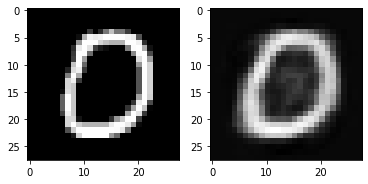

In [35]:
# propagate a sample
"""
INSERT CODE HERE
"""
# i=random.randint(0,200)
label = test_loader.dataset[i][1]
img_in = test_loader.dataset[i][0].view(-1, 28 * 28).to(device)    # view(-1, 28 * 28) to flatten the image to a vector
img_out = net_ae(img_in)

# show the result
"""
INSERT CODE HERE
"""
plt.subplot(1, 2, 1)
plt.imshow(img_in.view(28, 28).cpu().numpy(), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(img_out.view(28, 28).detach().cpu().numpy(), cmap='gray')
plt.show()

The network is able to reconstruct the data fairly decent. The result is slightly blurry, however, research has shown that the L1 loss can be a good alternative to mitigate this issue. Also note that the network is slightly overfitting. This can be improved to an extent with data augmentation (e.g. small rotations and/or shifts)

## 4. Clustering with autoencoders

In this section, we will show you how you can cluster data with an autoencoder model. Perhaps the simplest approach is to cluster the data in the encoded space, e.g. using k-means clustering. 

**Exercise**: Cluster the MNIST test data using the encodings and k-means clustering
- Compute the embeddings of the test data and store them in a numpy array
- Apply k-means clustering on the embeddings
- Evaluate the clustering with the [adjusted rand score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score). 

In [51]:
def compute_embeddings(net, loader):
    """
    INSERT CODE HERE
    """
    net.eval()
    embeddings = np.zeros((len(loader.dataset), dim_hidden))
    i = 0
    for x, _ in loader:
      x = x.view(-1, 28 * 28).to(device)
      h = net.encoder(x).detach().cpu().numpy()
      n = h.shape[0]
      embeddings[i:i+n, :] = h
      i += n

    return embeddings

# compute the embeddings of the autoencoder on the test set
"""
INSERT CODE HERE
"""
h = compute_embeddings(net_ae, test_loader)

# cluster the embeddings
"""
INSERT CODE HERE
"""
kmeans = KMeans(n_clusters=10, random_state=seed).fit(h)
kmeans_labels = kmeans.labels_ 
true_labels = test_loader.dataset.targets.numpy()

# evaluate
"""
INSERT CODE HERE
"""
ars = adjusted_rand_score(true_labels, kmeans_labels)
print(f'Adjusted rand score: {ars:3f}')


Adjusted rand score: 0.383763


The following code will compare the true labels and the clustering results. Note that the colors do not necessarily correspond to the same cluster. 

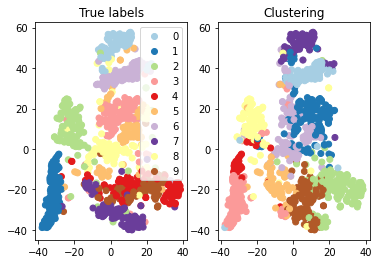

In [52]:
# reduce the dimensionality of the hidden representations
h_red = TSNE(n_components=2, random_state=seed).fit_transform(h[:1000])

# visualize the reduced representations and label each sample
plt.subplot(1, 2, 1)
scatter = plt.scatter(h_red[:, 0], h_red[:, 1], c=labels[:1000], cmap='Paired')
plt.legend(handles=scatter.legend_elements()[0], labels=range(10))
plt.title('True labels')
plt.subplot(1, 2, 2)
scatter = plt.scatter(h_red[:, 0], h_red[:, 1], c=predictions[:1000], cmap='Paired')
plt.title('Clustering')
plt.show()

The clusters seem to overlap with some of the label groups. Nevertheless, the results can be improved significantly with more state-of-the-art approaches that include a cluster regularization loss. 

We will now focus towards the extracted features of the autoencoder. Within the encoder, there are connections to each pixel for each hidden variable. In other words, we can visualize which pixels are important to activate a particular hidden variable. 

**Exercise**: Visualize the extracted features based on the matrix weights from the encoder. 
- Extract the encoder matrix parameter values
- For each hidden variable, reshape the corresponding features connected to the input to a $28 \times 28$ image 
- Visualize all these images

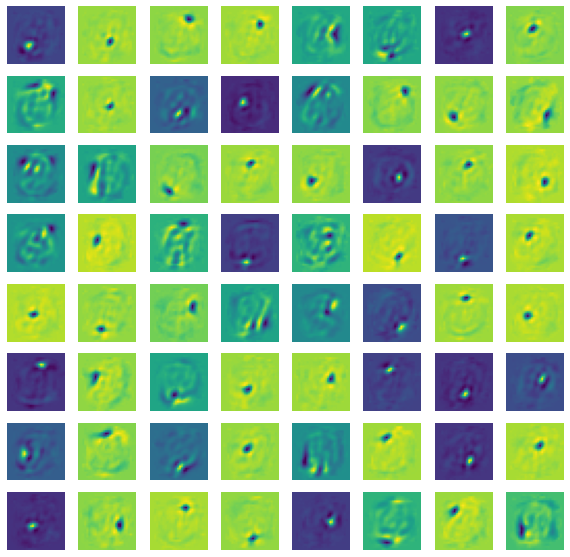

In [61]:
# extract the matrix parameters
"""
INSERT CODE HERE
"""
#print(list(net_ae.encoder.parameters()))
w = list(net_ae.encoder.parameters())[0]

# visualize the features
"""
INSERT CODE HERE
"""
k = 8  # we are using 64 = 8 * 8 hidden units, each of these 64 units has a weights to the 28x28 input pixels
plt.figure(figsize=(10,10))
for i in range(k):
    for j in range(k):
        plt.subplot(k, k, i*k+j+1)
        plt.imshow(w[i*k+j,:].view(28, 28).cpu().detach().numpy())
        plt.axis('off')
plt.show()

The extracted features can clearly be classified in three groups: features that extract global information and resemble (partial) objects and features that either add or subtract local blobs. The combination of these features appears to be the best setting to reconstruct digits. 

## 5. Semi-supervised classification

Semi-supervised classification aims to use large amounts of unlabeled data and a limited amount of labeled data for maximum classification performance. We will see that the extracted features of an autoencoder can serve as suitable features for classification. 

**Exercise**: Train and validate an SVM for increasing amounts of labeled training data. 
- Compute the embeddings of the train and test data. 
- Implement the `train_svm` function that trains an SVM with training $n$ samples. 
- Implement the `test_svm` function that tests an SVM on the complete test set and reports the accuracy. 
- Train an SVM for various amounts of labeled data with the autoencoder embeddings as input. 
- As a baseline, compare this approach to an SVM that is trained on the actual pixel values instead of the encodings. 

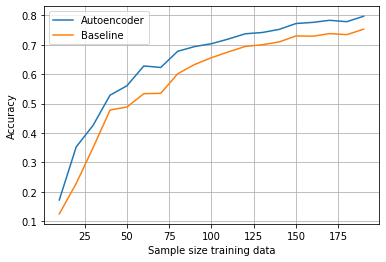

In [63]:
def train_svm(x_train, y_train, n):
    """
    INSERT CODE HERE
    """
    clf = svm.SVC()
    clf.fit(x_train[:n], y_train[:n])
    return clf

def test_svm(clf, x_test, y_test):
    """
    INSERT CODE HERE
    """
    y_pred = clf.predict(x_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    return acc

# compute the embeddings of the autoencoder on the train and test set
"""
INSERT CODE HERE
"""
h_train = compute_embeddings(net_ae, train_loader)
h_test = compute_embeddings(net_ae, test_loader)

# train and test an SVM for a varying amount of training data
n_train_min = 10
n_train_max = 200
n_train_step = 10
n_samples = np.arange(n_train_min, n_train_max, n_train_step)
accuracies_ae = np.zeros((len(n_samples)))
accuracies_bl = np.zeros((len(n_samples)))
for j in range(len(n_samples)):
    y_train = train_loader.dataset.targets.numpy()
    y_test = test_loader.dataset.targets.numpy()

    # autoencoder
    """
    INSERT CODE HERE
    """
    clf = train_svm(h_train, y_train, n_samples[j])
    acc = test_svm(clf, h_test, y_test)
    accuracies_ae[j] = acc

    # baseline
    """
    INSERT CODE HERE
    """
    clf = train_svm(train_loader.dataset.data.numpy().reshape((-1, 28*28)), y_train, n_samples[j])
    acc = test_svm(clf, test_loader.dataset.data.numpy().reshape((-1, 28*28)), y_test)
    accuracies_bl[j] = acc

# visualize the results
"""
INSERT CODE HERE
"""
plt.plot(n_samples, accuracies_ae)
plt.plot(n_samples, accuracies_bl)
plt.xlabel('Sample size training data')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(('Autoencoder', 'Baseline'))
plt.show()

We see a clear improvement of approximately 10% by using the extracted features of the autoencoder for classification. This is an example that shows that unlabeled data can also improve classifiers, i.e. that semi-supervised approaches are worth investigating. 